In [1]:
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

## Сырые данные по РФ


In [2]:
# Пример данных
df = pd.read_csv('regional_data/raw_Российская_Федерация.csv')
y = df["inflation"] / 100
df.drop(['inflation', 'Date'], axis=1, inplace=True)
df.head()

trade_turnover    debt_firms  money_income  paid_services  unemp  \
0 1840650960.8000 18171671.0000    29535.0000 559456677.9000 1.2000   
1 1853102881.7600 18184819.0000    29233.0000 571950883.8000 1.2000   
2 2032552773.8200 18458002.0000    31403.0000 591568267.2000 1.3000   
3 2023565042.7000 18790056.0000    32949.0000 599205733.8000 1.2000   
4 2075030365.1200 19052987.0000    32270.0000 585407816.1000 1.0000   

   fm_changes_volume  fm_changes_costs  fm_changes_demand  fm_volume_exp  \
0           -33.6366           16.5488           -18.9968        19.5241   
1             0.2397           19.8500            -5.4247        22.3260   
2            10.3180           21.9860             0.5802        21.6463   
3             3.7917           19.2108             0.6118        21.7094   
4            -0.0284           17.3341            -1.8377        20.1813   

   fm_demand_exp  ...  fm_consumer_risk  fm_price_final_prod  fm_ibk  \
0        17.8629  ...          -26.8843               8.8840 -5.1940   
1        20.6132  ...          -12.1922               9.0326  9.0811   
2        20.2543  ...           -6.8871               9.2950 13.0283   
3        19.7543  ...           -7.2642               8.4533 11.2594   
4        17.8731  ...           -9.3358               6.1958  8.8062   

   fm_econom_position  fm_econom_cond    Brent  MIACR  Infl_exp         M2  \
0             -3.6629        -13.8711 108.1200 6.0565   13.0377 31155.6000   
1             -3.0289         -7.6790 108.9000 5.9935   11.7952 29861.2000   
2             -2.5626         -4.1967 107.4800 7.8450   11.5221 30169.0000   
3             -1.8274         -3.6375 107.7600 7.8745   12.6727 29519.3000   
4             -0.9382         -3.2577 109.5400 8.2147   11.7210 29879.0000   

   obligates  
0     6.2005  
1     6.3855  
2     7.4024  
3     7.4977  
4     7.9550  

[5 rows x 23 columns]

## Как выглядит распределение рядов без обработки


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

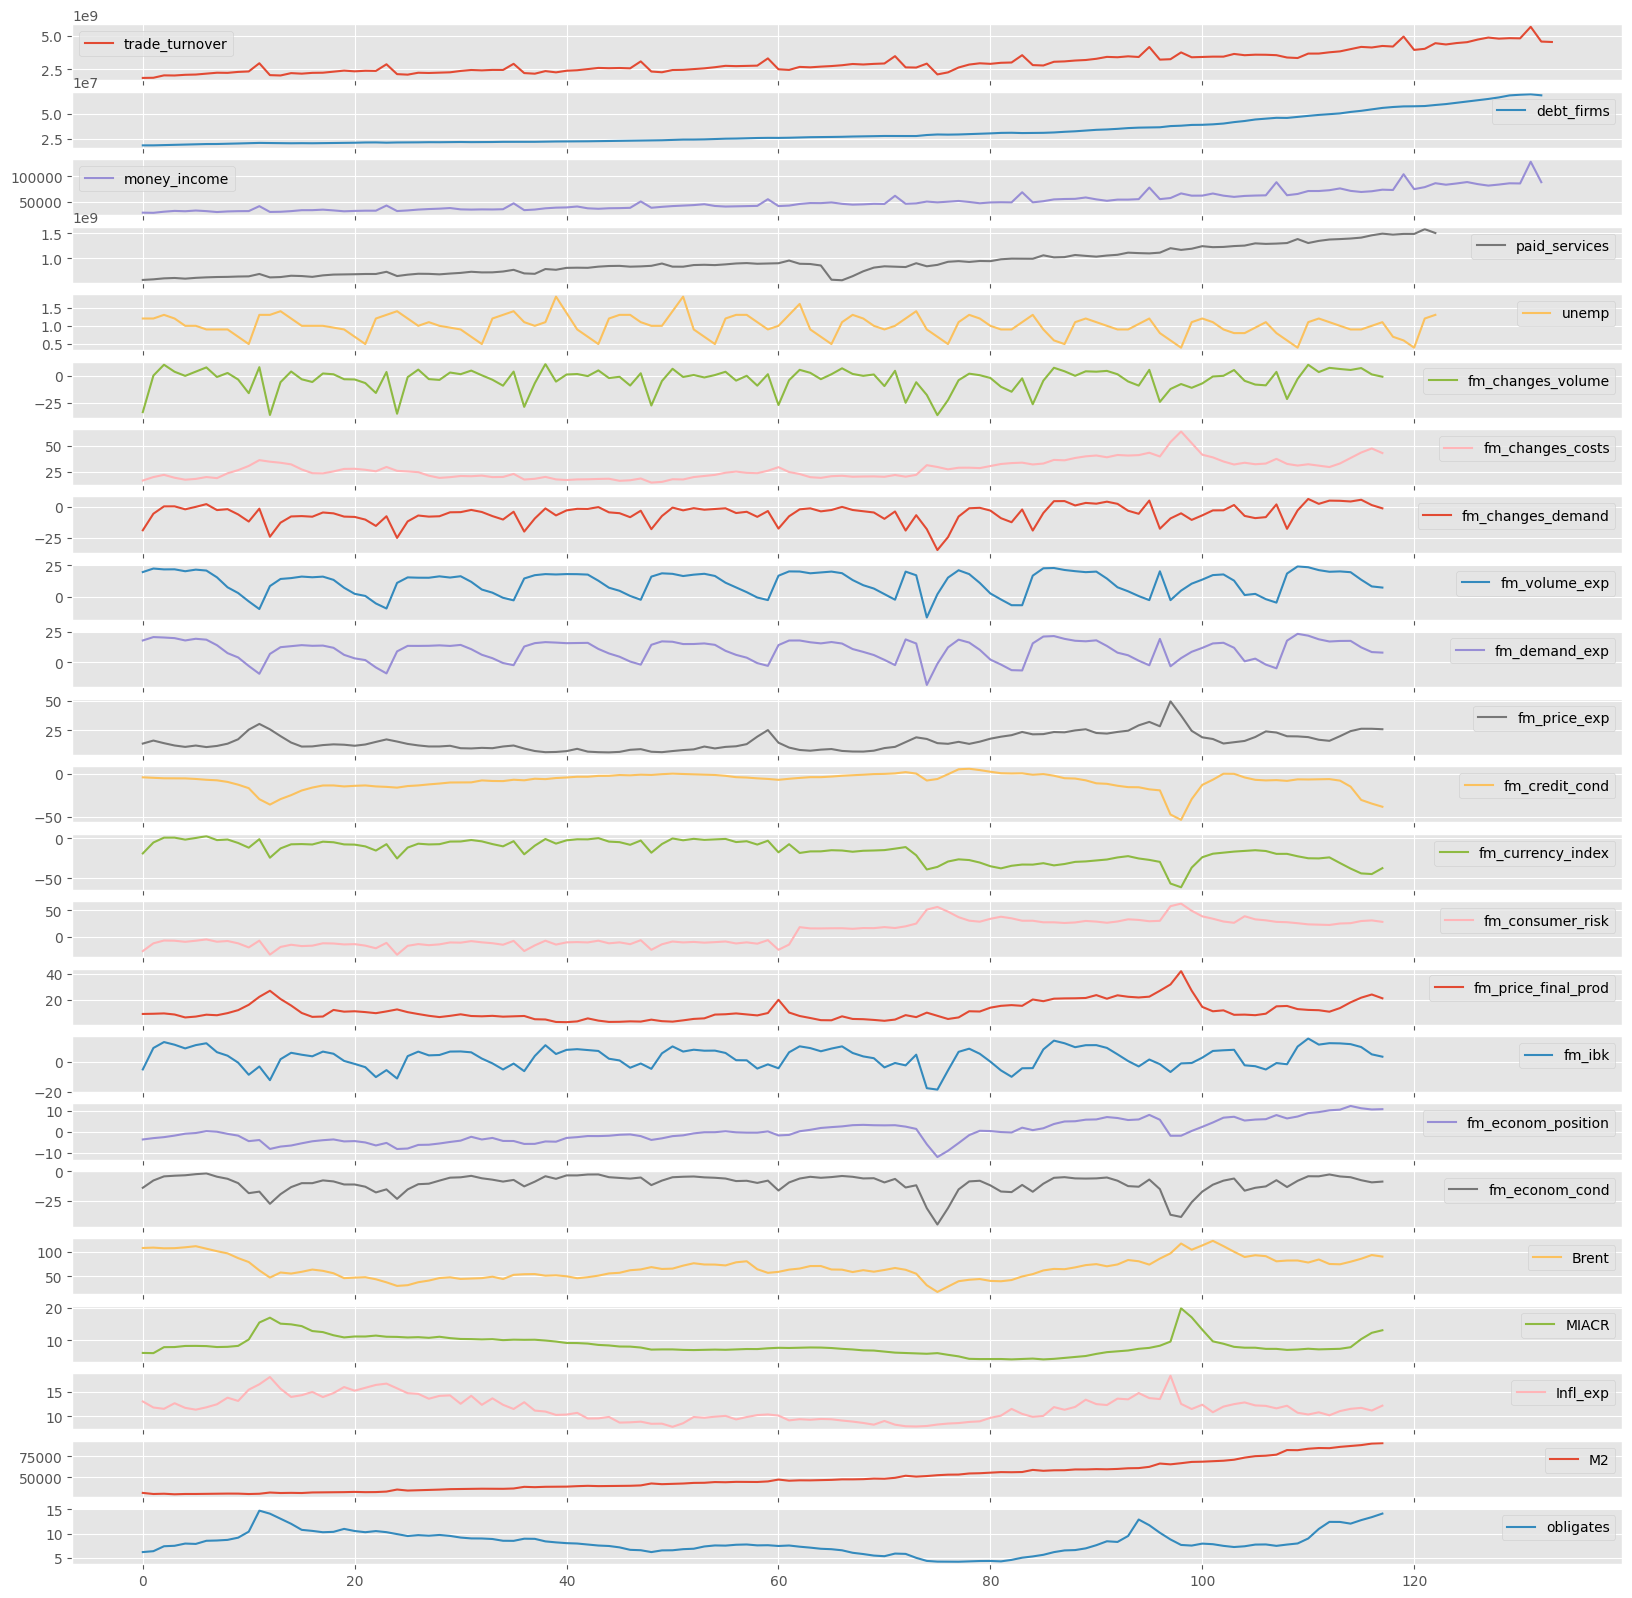

In [3]:
df.plot(kind='line', figsize=(20, 20), subplots=True)

## У денежных переменных вычищаем инфляцию


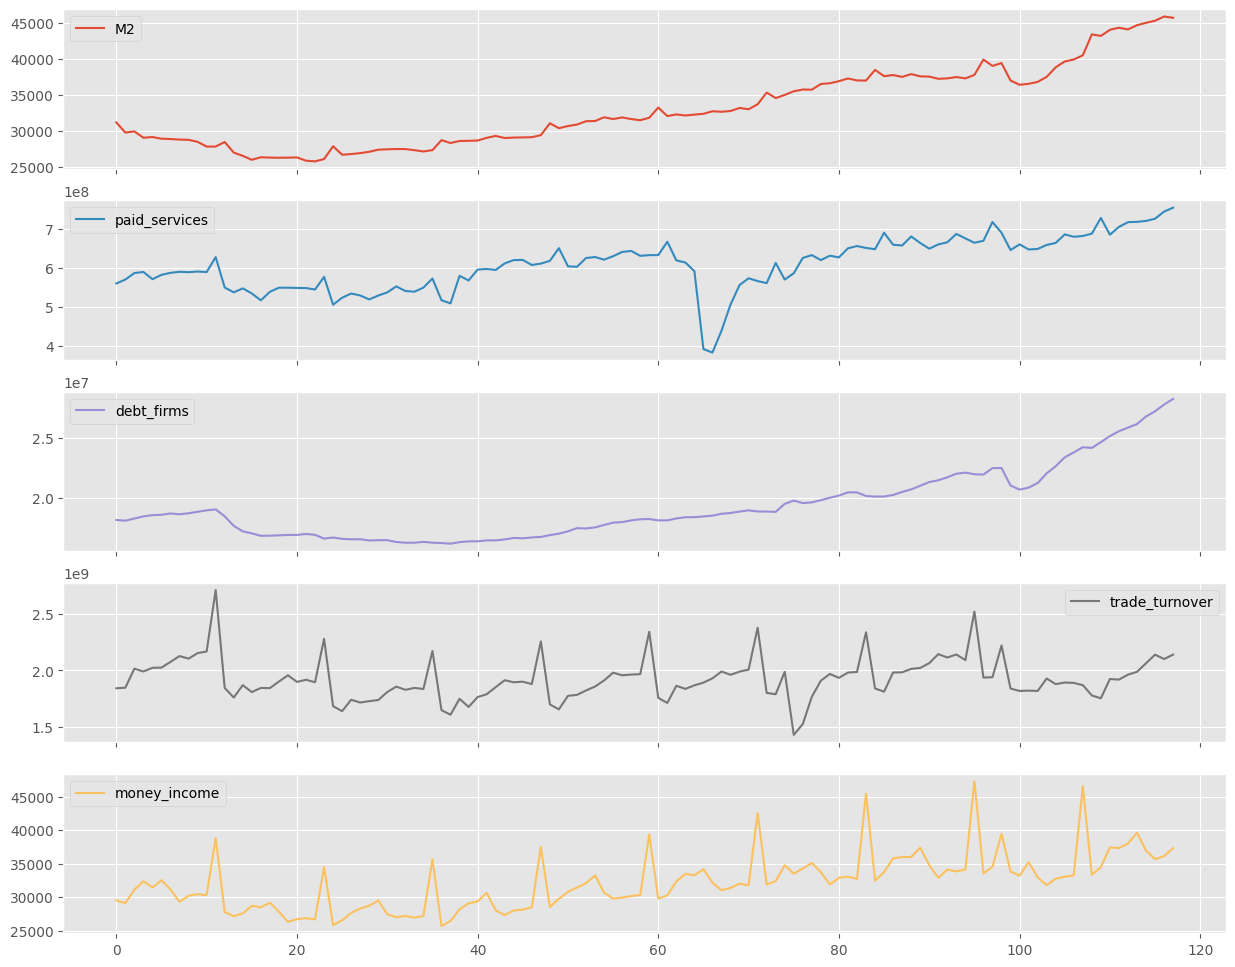

In [4]:
df_infl = df[['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
df_infl = df_infl.dropna()
y = y.dropna()
for col in df_infl:
    for i in range(len(df_infl[col])):
        for j in range(i):
            df_infl.loc[i, col] = df_infl.loc[i, col] / y[j]
df = df.join(df_infl)
df_infl.plot(kind='line', figsize=(15, 12), subplots=True);

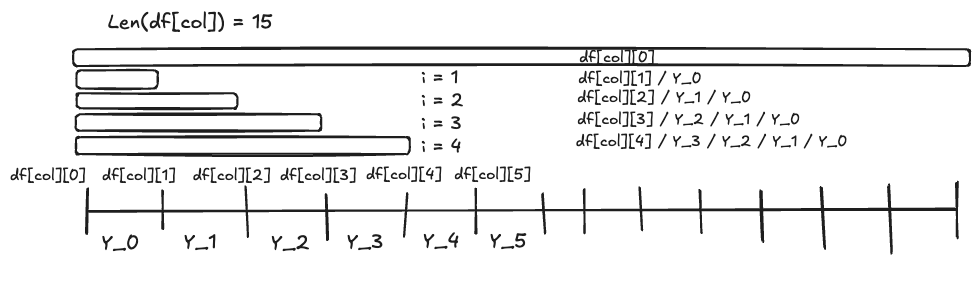


## Находим ряды с большой размерностью / экспоненциальным ростом и применяем логарифмирование


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

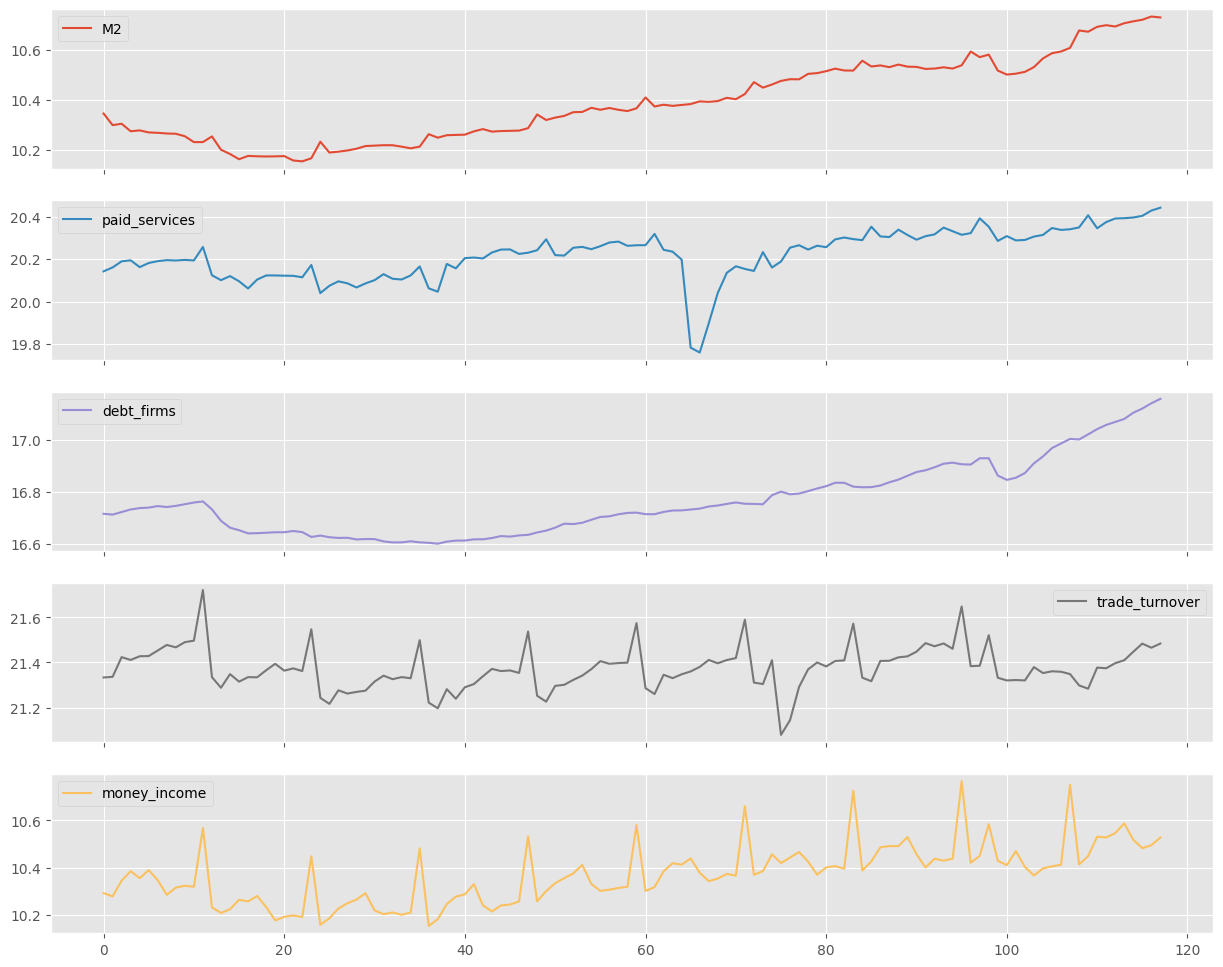

In [5]:
df_log = df[['M2', 'paid_services', 'debt_firms','trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover','money_income'], axis=1, inplace=True)
df_log = df_log.apply(lambda x: np.log(x))
df = df.join(df_log)
df_log.plot(kind='line', figsize=(15, 12), subplots=True)

## Ищем ряды с ярко выраженной годовой сезонностью и применяем сезонную корректировку


In [6]:
from statsmodels.tsa.seasonal import STL

df = df.dropna()

df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                  'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                  'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms']].copy()

df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
         'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
         'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
df_seasonal = df_seasonal.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df = df.join(df_seasonal)

Отдельно вычищаем безработицу, так как у неё сезонность по 11 месяцев


<Axes: >

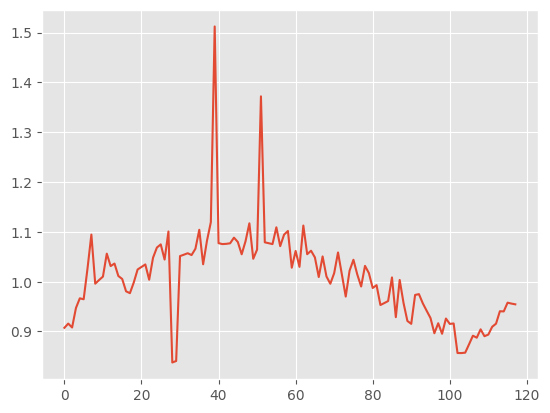

In [7]:
df['unemp'] = df['unemp'] - STL(df['unemp'], period=11).fit().seasonal
df['unemp'].plot()

## Берем первые разности и приводим ряды к 1 размерности

### Проверяем ряды на стационарность


In [8]:
a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
df.loc[:, a_list] = df.loc[:, a_list].diff(1)
df = df.diff(1)
df = df.dropna()
df.apply(lambda x: adfuller(x)[1] < 0.05)

unemp                  True
fm_changes_costs       True
fm_price_exp           True
fm_credit_cond         True
Brent                  True
MIACR                  True
Infl_exp               True
obligates              True
fm_changes_volume      True
fm_changes_demand      True
fm_volume_exp          True
fm_demand_exp          True
fm_currency_index      True
fm_consumer_risk       True
fm_price_final_prod    True
fm_ibk                 True
fm_econom_position     True
fm_econom_cond         True
M2                     True
paid_services          True
money_income           True
trade_turnover         True
debt_firms             True
dtype: bool

## Итоговое распределение рядов


## Применяем Метод главных компонент для переменных - опроссов коньюктуры рынка

### Формируем компоненты, объясняющие 90% дисперсии Х


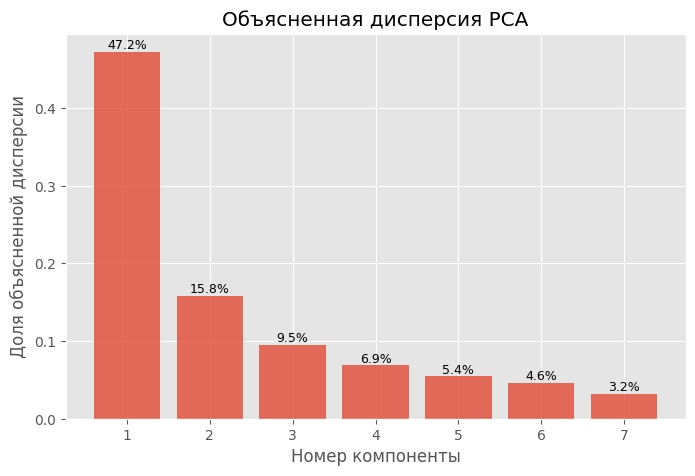

In [9]:
df = df.dropna()
X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
           'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
           'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()

X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']

X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                     'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                     'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fm)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
bars = plt.bar(range(1, len(explained_variance) + 1),
               explained_variance, alpha=0.8, align='center')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.xticks(np.arange(1, len(explained_variance)+1, 1))
plt.title('Объясненная дисперсия PCA')
plt.show()

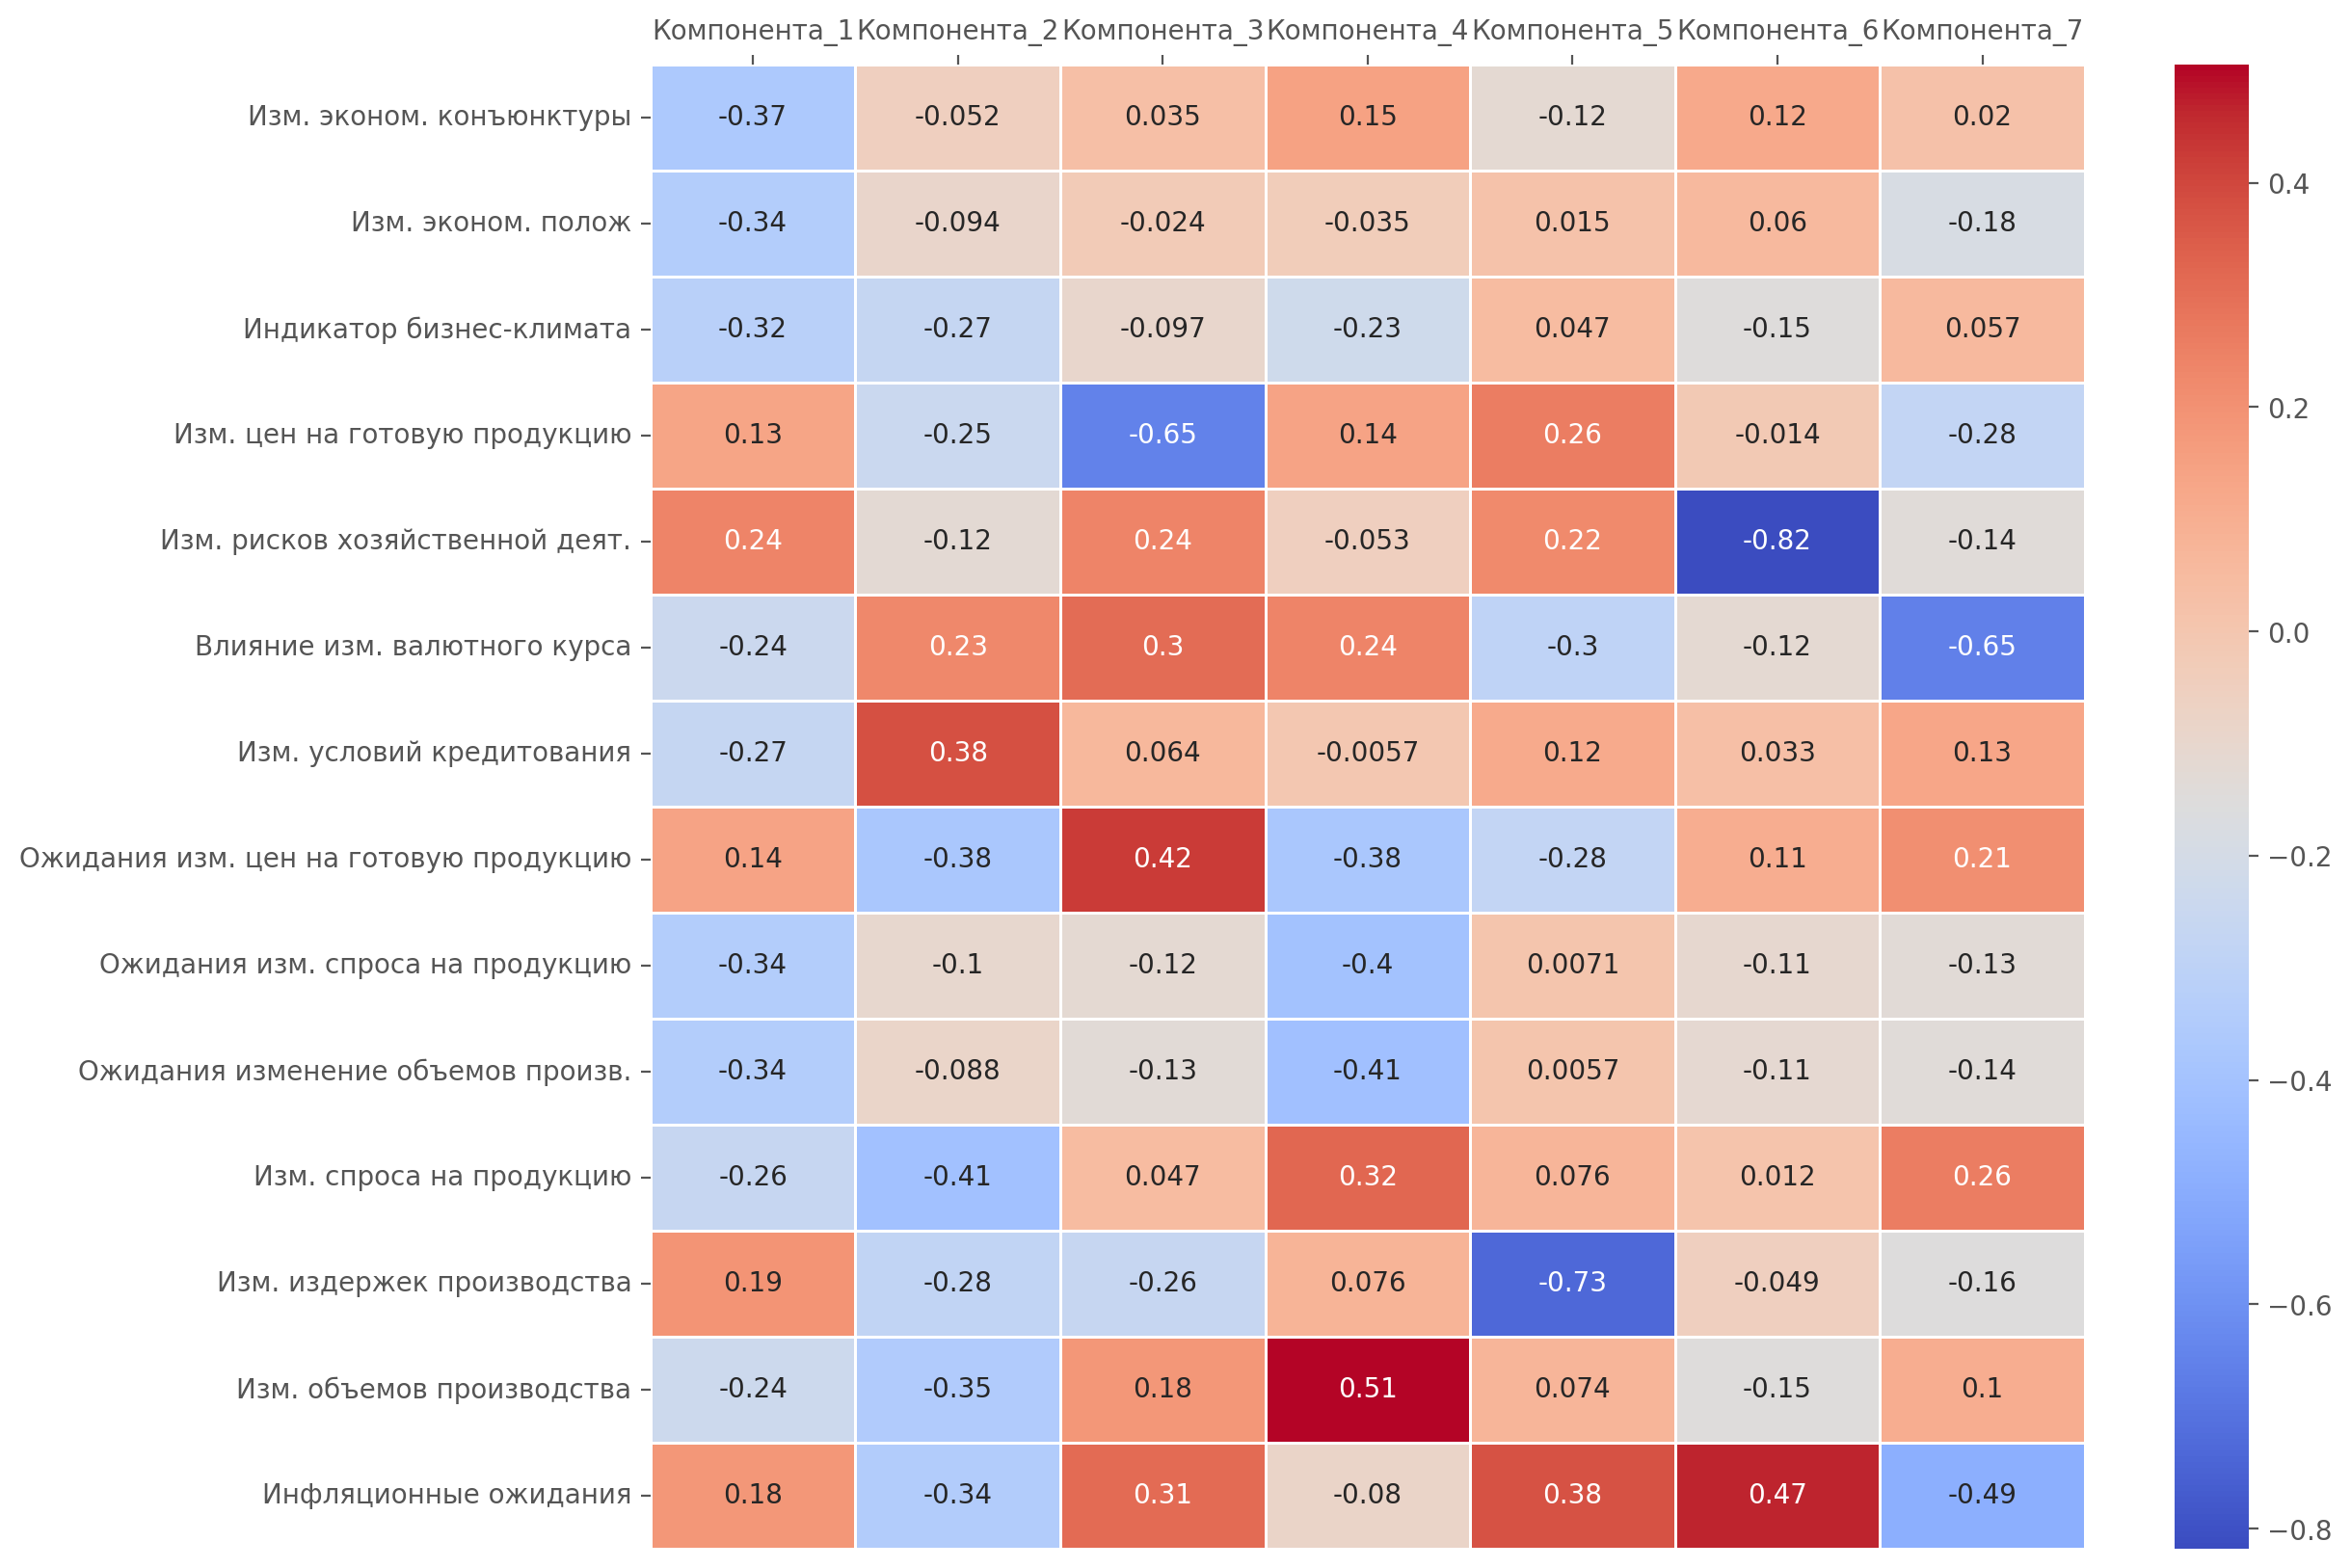

In [10]:
plt.figure(figsize=(12, 10), dpi=200)
loadings_data = pd.DataFrame(
    loadings, columns=X_fm.columns, index=range(1, 1+len(loadings))).T
loadings_data.columns = [f'Компонента_{i}' for i in range(1, 1+len(loadings))]
ax = sb.heatmap(loadings_data, annot=True, cmap='coolwarm', linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [11]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.columns = [f'PCA_{j+1}' for j in range(len(X_pca[0]))]
X = X.join(X_pca_df).dropna()
X

unemp    Brent   MIACR  obligates      M2  paid_services  money_income  \
2   -0.0162  -2.2000  1.8515     0.8319  0.0038        -0.0222        0.0149   
3    0.0470   1.7000  0.0295    -0.9215 -0.0126         0.0167       -0.0202   
4   -0.0198   1.5000  0.3402     0.3619  0.0001        -0.0030       -0.0085   
5   -0.0212   0.4800  0.0184    -0.5299  0.0005        -0.0360        0.0143   
6    0.0637  -7.2900 -0.0610     0.7176  0.0056         0.0189       -0.0053   
..      ...      ...     ...        ...     ...            ...           ...   
111  0.0124  10.3700 -0.1946     0.9454  0.0252         0.0511        0.0825   
112 -0.0093 -15.3800  0.0915    -0.5172 -0.0245        -0.0451       -0.0462   
113  0.0186   8.5400  0.0809    -1.4646  0.0016        -0.0202       -0.0238   
114 -0.0253   5.9000  0.4952    -0.3420 -0.0021         0.0287        0.0101   
115  0.0179   0.7700  2.5042     1.0788 -0.0064         0.0086        0.0026   

     trade_turnover  debt_firms   PCA_1   PCA_2   PCA_3   PCA_4   PCA_5  \
2           -0.0064     -0.0016 -0.0824  0.4798  0.1093  0.1769 -0.7961   
3           -0.0042     -0.0073  0.5033  0.1017 -0.1089 -0.4461 -0.8194   
4           -0.0071     -0.0016 -0.6406 -0.6197  0.6106  0.9384  0.0635   
5            0.0009     -0.0065  0.6557  0.2963 -0.2016 -0.8255  0.6495   
6           -0.0069      0.0018  0.7380 -1.1284  0.3992  0.6541 -0.5781   
..              ...         ...     ...     ...     ...     ...     ...   
111          0.0764      0.0233  0.9551 -0.3633  0.6569 -0.6509 -1.2314   
112         -0.0435     -0.0226 -0.0886 -1.0080  0.3600  0.4841 -0.3540   
113         -0.0046     -0.0090  0.9764 -0.1258 -0.6199 -0.1153  0.0416   
114          0.0068      0.0018 -3.2908  0.4643  0.1230  0.1389 -0.1646   
115         -0.0270     -0.0083  0.3354  0.6928  1.4894 -0.3228  1.7583   

      PCA_6   PCA_7  
2   -0.0029  0.6395  
3    0.0628  0.1965  
4   -0.4568 -0.3467  
5    0.8758 -0.1290  
6    0.2924 -0.7456  
..      ...     ...  
111  0.7815 -0.3403  
112  0.0623 -0.2912  
113 -0.0064 -0.6872  
114  0.6160  0.6779  
115 -0.4908 -0.6091  

[114 rows x 16 columns]

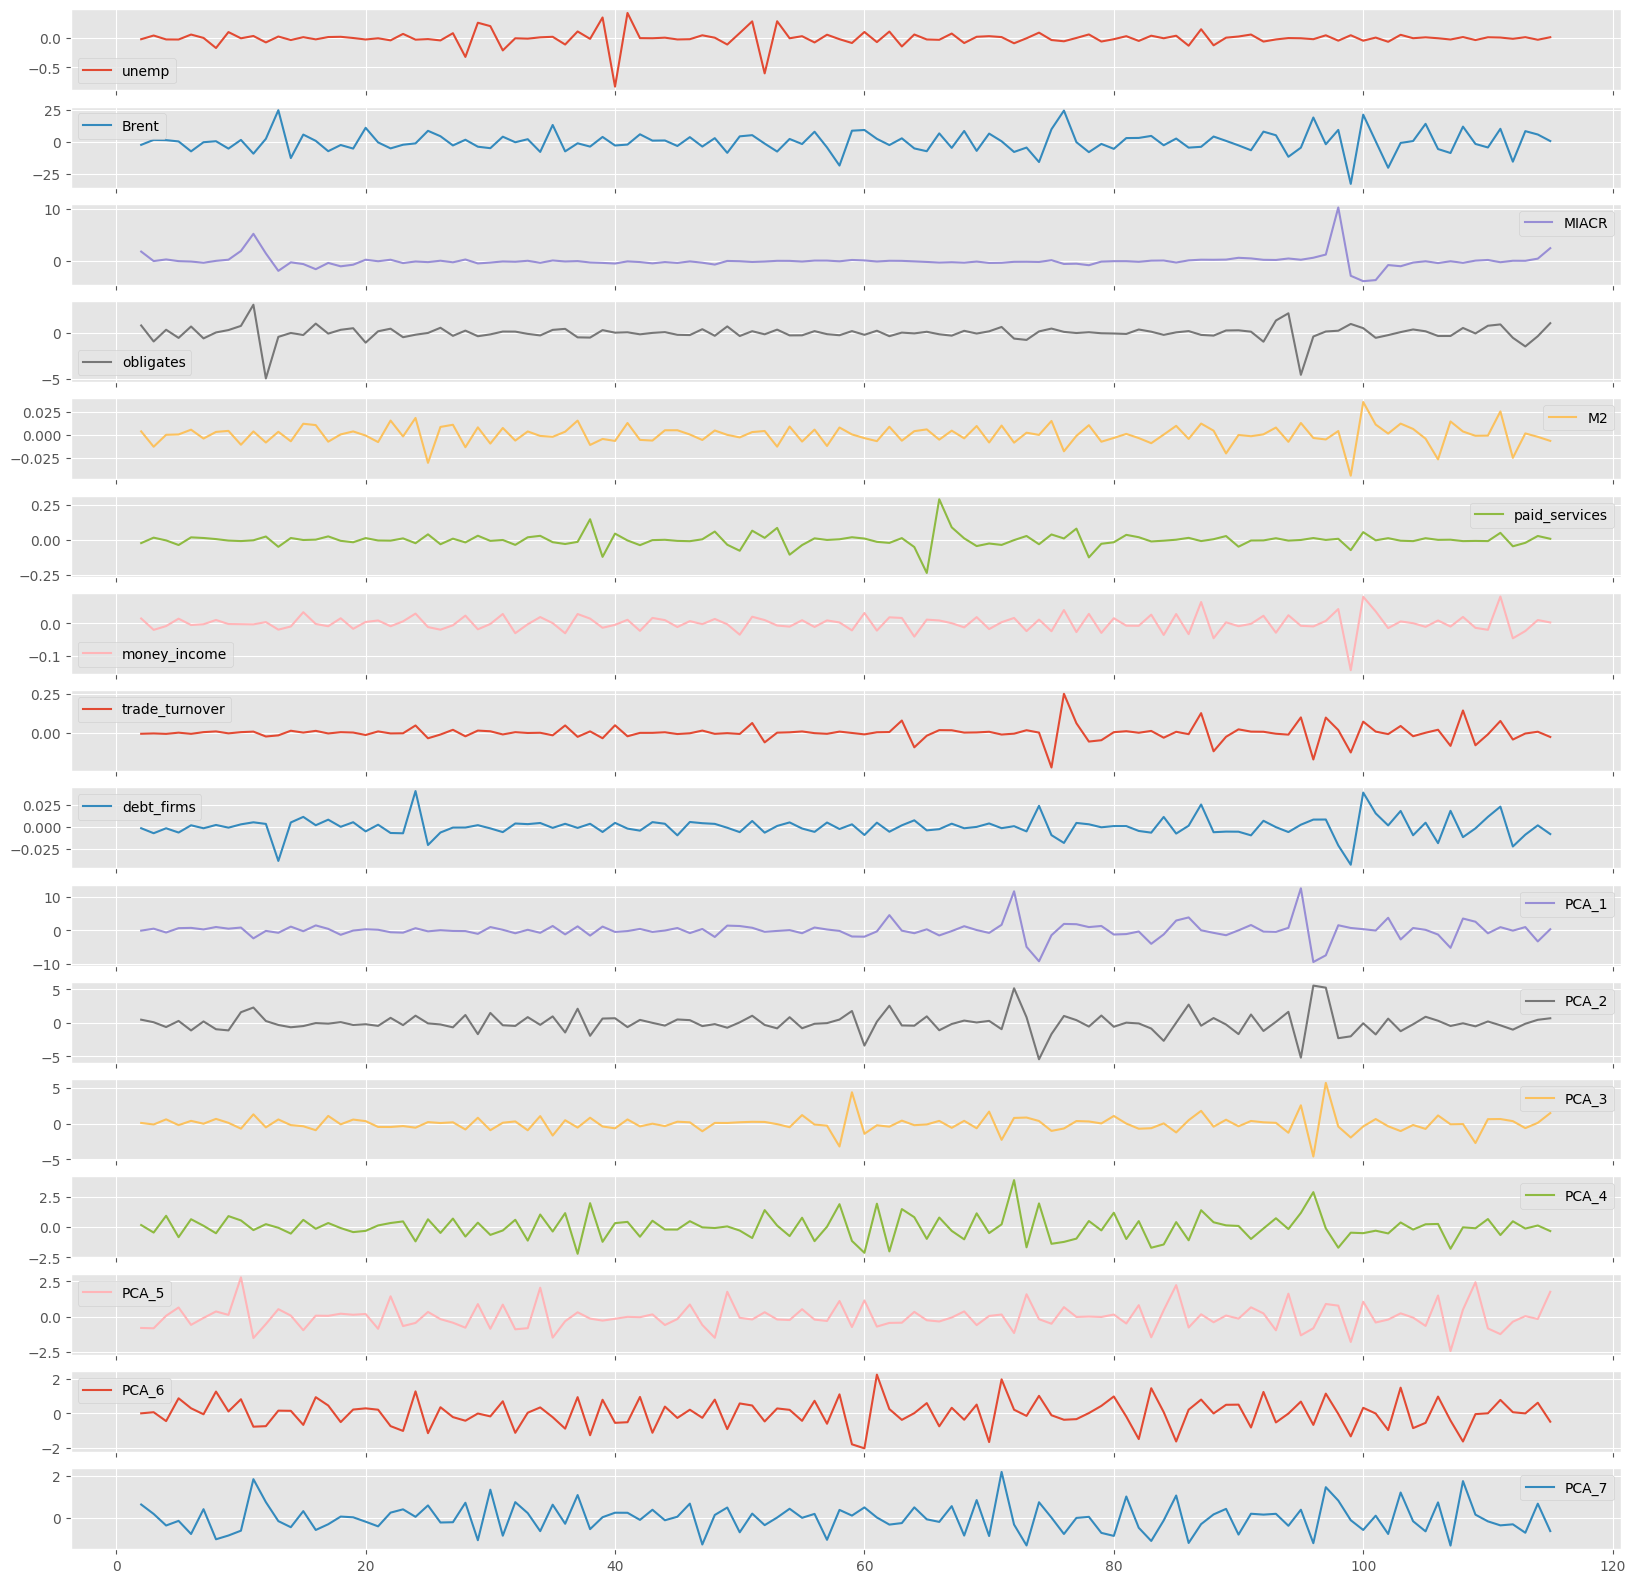

In [12]:
X.plot(subplots=True, figsize=(20, 20));

In [13]:
import os
os.makedirs('final_regional_df', exist_ok=True)
os.path.join(os.getcwd(), 'processed_regional_data')

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/processed_regional_data'

In [14]:
df = X.join(y)
df.to_csv('final_regional_df/infl_Российская_Федерация.csv', index=False)

<Axes: >

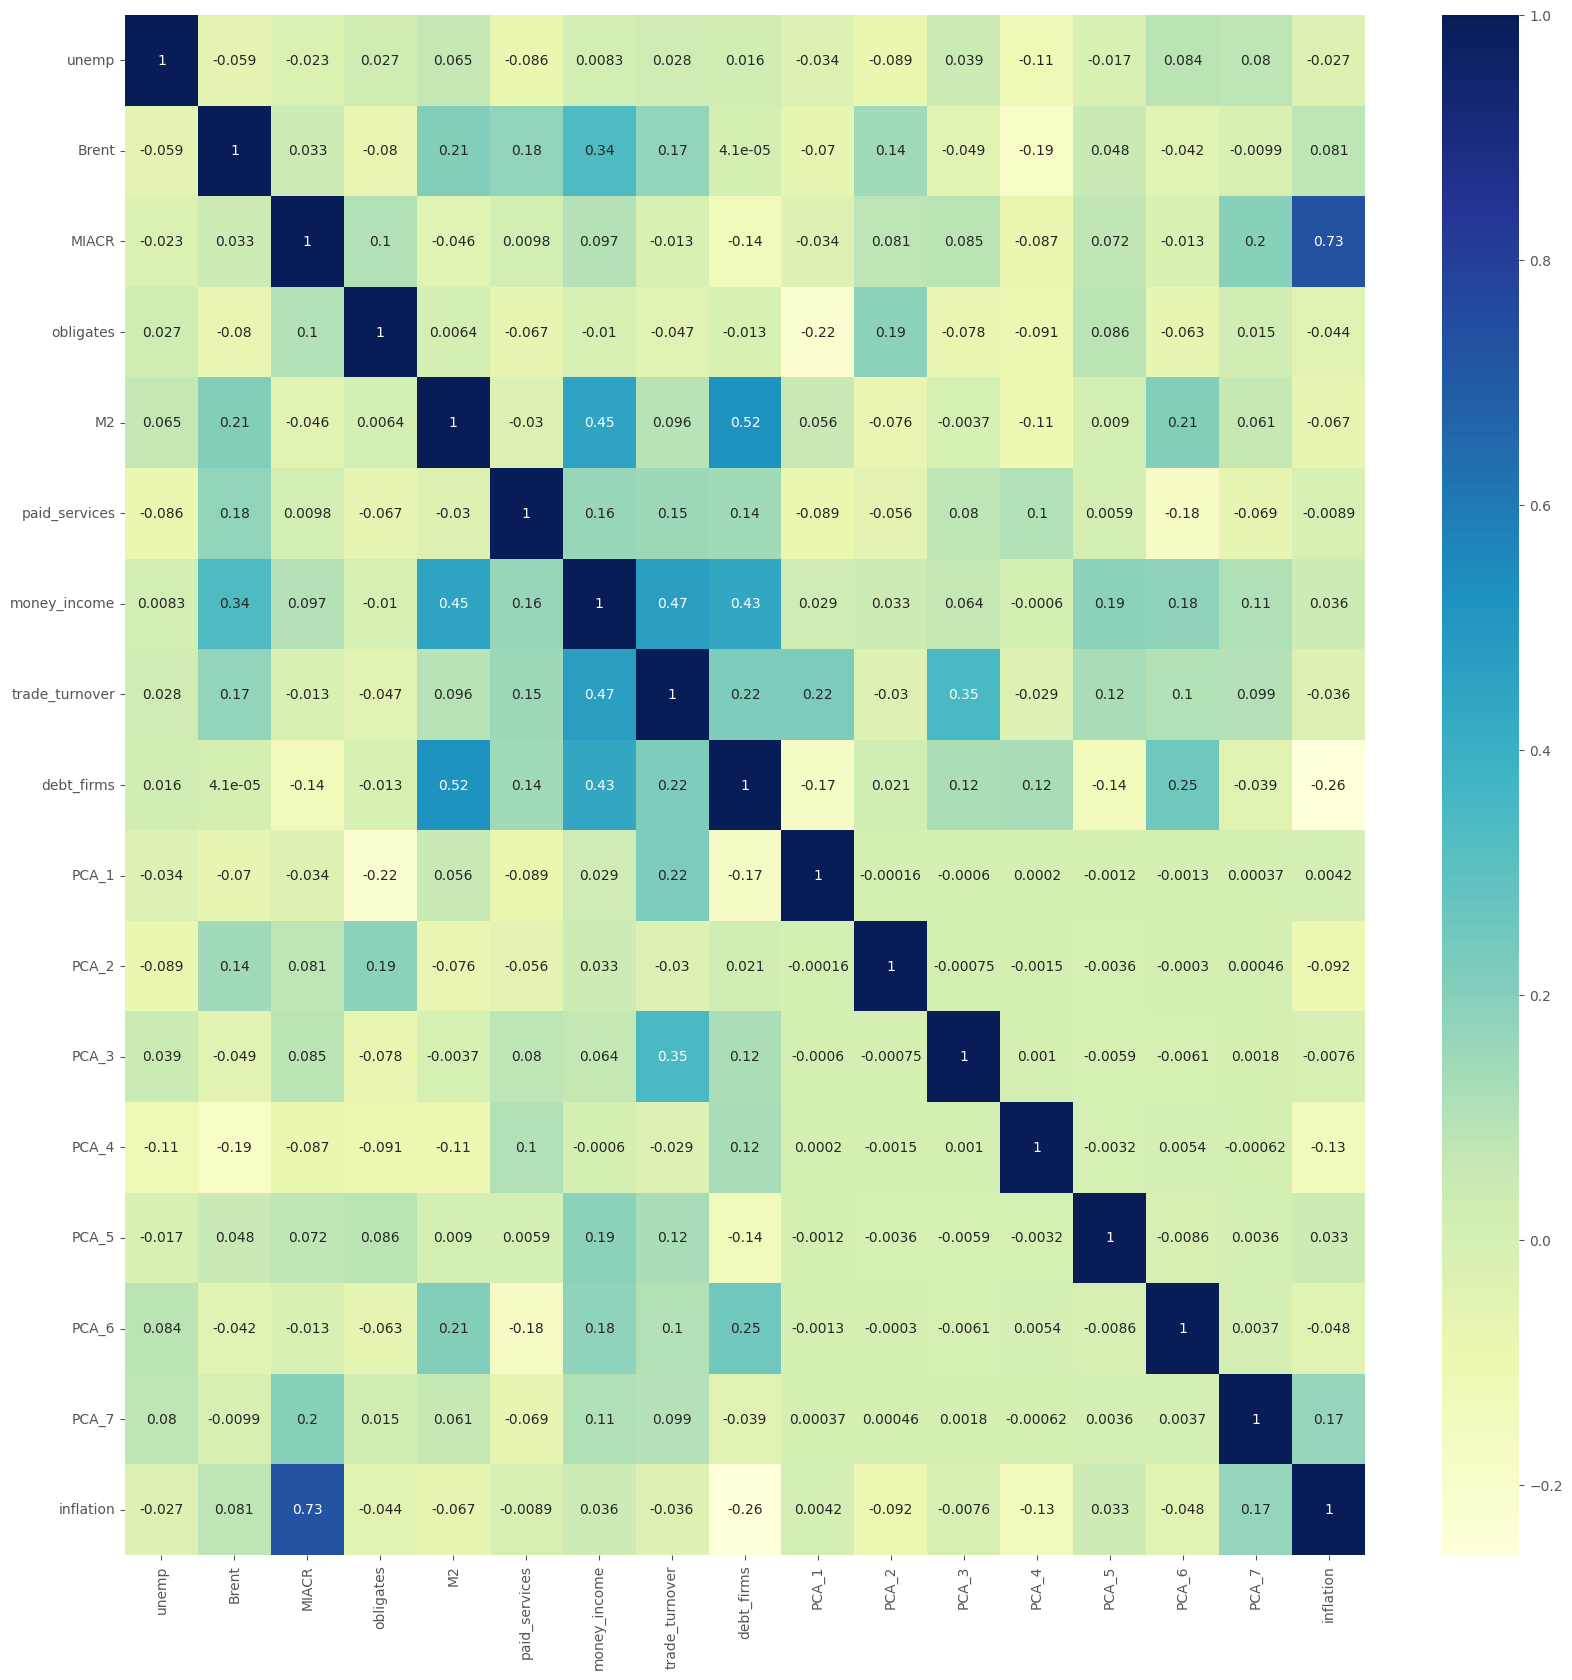

In [15]:
plt.figure(figsize=(20, 20))
sb.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

## Создание региональных таблиц по общему алгоритму

In [16]:
# Собираем списком названия файлов в папке
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
# Создаем папку, куда будем сохранять наши файлы
os.makedirs('final_regional_df', exist_ok=True)
# Создаем переменной название пути до папки с файлами (понадобится при импорте)
source_path = os.path.join(os.getcwd(), 'regional_data')


for k in range(len(file_names)):
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[k])}').dropna()
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    # У денежных рядов делаем корректировку на инфляцию (чтобы инфляция не объясняла сама себя)
    df_infl = df[['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
    df_infl = df_infl.astype(float).dropna()
    df_infl.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    for col in df_infl:
        for i in range(len(df_infl[col])):
            for j in range(i):
                df_infl.loc[i, col] = df_infl.loc[i, col] / y[j]
    df = df.join(df_infl)
    # Логарифмируем ряды с большой размерностью
    df_log = df[['M2', 'paid_services', 'debt_firms','trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover','money_income'], axis=1, inplace=True)
    df_log = df_log.apply(lambda x: np.log(x))
    df = df.join(df_log)
    # Делаем сезонную корректировку рядов
    df = df.dropna()
    df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                      'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                      'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms']].copy()
    df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
             'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
             'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
    df_seasonal = df_seasonal.apply(
        lambda x: x - STL(x, period=12).fit().seasonal)
    df = df.join(df_seasonal)
    df['unemp'] = df['unemp'] - STL(df['unemp'], period=11).fit().seasonal
    # Приводим к стационарности с помощью 1 разностей
    a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
    df.loc[:, a_list] = df.loc[:, a_list].diff(1)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
               'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
               'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    # Циклом проходимся по кол-ву главных компонент
    X_pca_df = pd.DataFrame(X_pca)
    X_pca_df.columns = [f'PCA_{t+1}' for t in range(len(X_pca[0]))]
    X = X.join(X_pca_df).dropna()
    df = X.join(y)
    df.to_csv(f'final_regional_df/infl_{file_names[k][4:-4]}.csv', index=False)

## Распределение объясненной дисперсии по компонентам


In [17]:
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(160, 100), dpi=100)

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
               'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
               'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    bars = axes[row, col].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center')
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[row, col].set_xticks(np.arange(1, len(explained_variance)+1, 1))
    axes[row, col].set_title(f'{file_names[i][4:-4]}', fontsize=30)
plt.savefig('result/pca_region.pdf')

## Распределение переменных по компонентам


In [101]:
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(180, 180), dpi=100)

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df.loc[:, ['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                      'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                      'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.',
                    'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию',
                    'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                         'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                         'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    loadings_data = pd.DataFrame(
        loadings, columns=X_fm.columns, index=range(1, 1+len(explained_variance))).T
    sb.heatmap(loadings_data, annot=True, cmap='coolwarm',
               linewidth=.5, ax=axes[row, col])
    plt.title(f'Состав компонент {file_names[0][4:-4]}')
plt.tight_layout()  # улучшает расположение подграфиков

# Попробуйте сначала PNG
plt.savefig('result/fm_in_pca.png', bbox_inches='tight')
plt.close()